# Optimising server utilisation
The goal is to create a diagram showing the optimal server utilisation as a percentage of the time active based on all given system parameters.

## Calculating the hourly server price
The hourly server price for given parameters will be written as:
$$\boxed{C_{\text{tot}}=\frac{n}{\varepsilon}\cdot\left[C_{\text{server}} + C_{\text{grid}} + W_{\text{base}} \cdot c_{\text{total}} + W_{\text{active}} \cdot c_{\text{max fee}} + W_{\text{active}} \cdot \left(c_{\text{grid}} + c\right) \cdot \varepsilon \right]}$$
where<p>
| Symbol               | Unit  | Description                                              |
|----------------------|-------|----------------------------------------------------------|
| $n$                  | 1     | Number of servers required at 100% utilisation           |
| $\varepsilon$        | 1     | Utilisation of the servers                               |
| $C_{\text{server}}$  | €/h   | Hourly (rent) cost of the servers                        |
| $C_{\text{grid}}$    | €/h   | Base hourly grid fee                                     |
| $W_{\text{base}}$    | W     | Idle power consumption of the servers                    |
| $W_{\text{active}}$  | W     | Active power consumption of the servers                  |
| $c_{\text{total}}$   | €/MWh | Mean power cost for server operation at 100% utilisation |
| $c_{\text{max fee}}$ | €/MWh | Cost for the upper limit of power consumption            |
| $c_{\text{grid}}$    | €/MWh | Grid fee / base power cost                               |
| $c$                  | €/MWh | Time- / utilisation-dependent power cost                 |

The equation takes the general form of
$$\frac{C_{\text{tot}}}{n}=\alpha\cdot c + \frac{\beta}{\varepsilon_{\text{utilisation}}} + \gamma$$
which can be optimised based on the given summands. These can represent the following variables:
- $\alpha = W_{\text{active}}$
- $\beta = C_{\text{server}}  + C_{\text{grid}} + W_{\text{base}} \cdot c_{\text{total}} + W_{\text{active}} \cdot c_{\text{max fee}}$
- $\gamma = W_{\text{active}} \cdot c_{\text{grid}}$

The parameter $\gamma$ max be neglected for the purpose of optimisation as it is constant and only provides an offset. Now we may define the total hourly cost of the servers while inactive as $C_{\text{server}} + C_{\text{grid}} + W_{\text{base}} \cdot c_{\text{total}} \equiv C_{\text{base}}$. Then the set of functions that needs to be optimised (as in analysed for local minima) is expressed as:
$$\boxed{f_{W_{\text{active}}, C_{\text{base}}, c_{\text{max fee}}}\left(c, \varepsilon\right)=W_{\text{active}}\cdot c + \frac{C_{\text{base}} + W_{\text{active}}\cdot c_{\text{max fee}}}{\varepsilon}}$$

The arguments of the function will be determined as pairs through the price data while its parameters are system dependent. Thus, different values for the parameters - if not given - should be tested within a reasonable order of magnitude. One must note that these values only correspond to one server.

$O(W_{\text{active}})=10^{-3}MW$


$O(C_{\text{total base}})=10^{-1}€/h$


$c_{\text{max fee}}\approx 16.7\ €/MW/h$ (see https://www.bonn-netz.de/fileadmin/dokumente/Unser_Netz/20250120_Preisblatt_Strom_2025_final.pdf)

The diagram will therefore depend on two parameters and be a 3d surface plot.

## Import libraries and fetch data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# uncomment for interactive 3d plot
#%matplotlib qt

import requests
import json

import os
import datetime
import time

In [2]:
fetch = False
days = 365
end = int(time.time())
start = end - 86400 * days

if fetch or not os.path.exists("price.json"):
    price = "https://api.energy-charts.info/price?country=de&start=" + str(start) + "&end=" + str(end)
    response = requests.get(price)
    if response.status_code == 200:
        price_data = response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
    with open("price.json", "w") as f:
        json.dump(response.json(), f, indent=4)
else:
    with open("price.json", "r") as f:
        price_data = json.load(f)

timestamps = [pt for pt in price_data['unix_seconds']]
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
price_data = [pt for pt in price_data['price']]

## Implementation of the derived functions

In [3]:
def server_cost(utilisation,
                          price_per_mwh, server_cost_per_hour,
                          server_base_consumption_mwh, server_active_consumption_mwh,
                          grid_fee_base=0, grid_fee_per_mwh=0, grid_fee_max=0, 
                          server_capacity_to_required_capacity=1):
    base_cost = server_cost_per_hour * server_capacity_to_required_capacity / utilisation
    base_consumption_cost = server_base_consumption_mwh * price_per_mwh * server_capacity_to_required_capacity / utilisation
    max_consumption_cost = grid_fee_max * server_active_consumption_mwh * server_capacity_to_required_capacity / utilisation
    active_consumption_cost = (grid_fee_per_mwh + price_per_mwh) * server_active_consumption_mwh * server_capacity_to_required_capacity
    return base_cost + base_consumption_cost + active_consumption_cost + max_consumption_cost + grid_fee_base

def opt_cost(utilisation, price_per_mwh, active_consumption, total_base_cost, grid_max_fee):
    return active_consumption * price_per_mwh + (total_base_cost + active_consumption * grid_max_fee)/ utilisation 

## Obtain price per consumed energy-utilisation datapoints
In order to obtain the price per consumed energy for a given utilisation, the time - price per consumed energy - chart will be used. A threshold is set above which the servers must not be running. The ratio between the time, the price per consumed energy is below the threshold and the total time interval of the data then represents the utilisation. By numerically integrating over the price per consumed energy for each price value below the threshold through approximation of rectangles one may followingly find the mean price per consumed energy for a given threshold and therefore a specific utilisation. As $\frac{df}{dc}=\text{const.}$, one may integrate over the price per consumed energy instead of integrating over the value of the function $f$.

In [4]:
probe_price = np.linspace(0, max(price_data), 100)
utilisation = np.ndarray((len(probe_price)))
price_sum = np.ndarray((len(probe_price)))
time_delta = timestamps[len(timestamps) - 1] - timestamps[0]

for n, probe in enumerate(probe_price):
    t_utilisation = 0
    price_times_dt = 0
    for i in range(1, len(price_data) - 1):
        if price_data[i] <= probe:
            dt = ((timestamps[i+1] - timestamps[i]) + (timestamps[i] - timestamps[i-1])) / 2
            t_utilisation += dt
            price_times_dt += dt * price_data[i]
    utilisation[n] = t_utilisation / time_delta
    price_sum[n] = price_times_dt / t_utilisation

## Show example utilisation - price per consumed energy - graph
For each of the $n=4288$ cores, the given values are:
- $W_{\text{active}}=1.1\cdot 10^{-5}MW$
- $C_{\text{base}}=12000€/(4\cdot 365\cdot 24h)/256\approx 0.00134€/h$
- $c_{\text{max fee}}=100€/MWh$

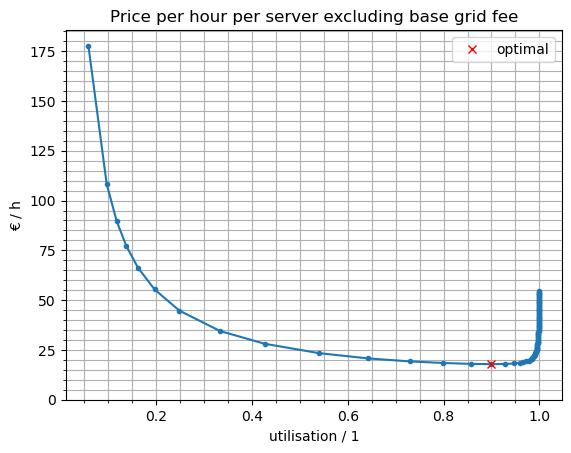

Optimal utilisation: 90.00%
Savings relative to 100% utilisation: 67.29%


In [5]:
oc = 4288  * opt_cost(utilisation, probe_price, 1.1e-5, 0.00134, 100)
plt.plot(utilisation, oc, ".-")
plt.plot(utilisation[np.argmin(oc)], np.min(oc), "rx", label="optimal")
plt.title("Price per hour per server excluding base grid fee")
plt.xlabel("utilisation / 1")
plt.ylabel("€ / h")
plt.ylim(0)
plt.grid(visible=True, which='both', axis='both')
plt.minorticks_on()
plt.legend()
plt.show()

print(f"Optimal utilisation: {utilisation[np.argmin(oc)]:.2%}\nSavings relative to 100% utilisation: {(1 - np.min(oc) / oc[-1]):.2%}")

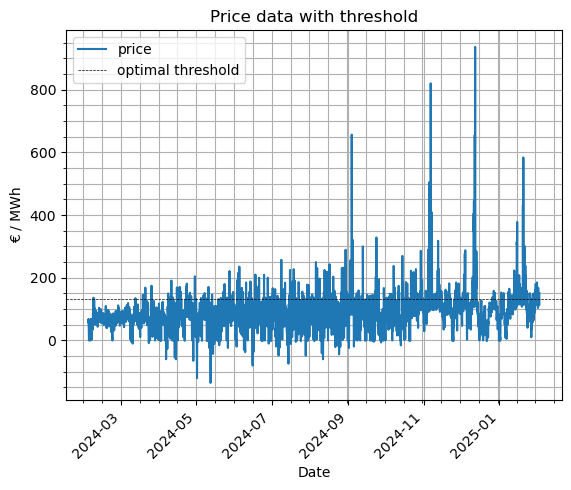

In [6]:
plt.plot(dates, price_data, label="price")
plt.title("Price data with threshold")
plt.xlabel("Date")
plt.ylabel("€ / MWh")
plt.grid(visible=True, which='both', axis='both')
plt.xticks(rotation=45, ha='right')
plt.axhline(probe_price[np.argmin(oc)], color='black', linestyle='--', linewidth=0.5, label="optimal threshold")
plt.grid(visible=True, which='both', axis='both')
plt.minorticks_on()
plt.legend()
plt.show()

## Calculate utilisation, threshold and lowest mean for the given range of function parameters

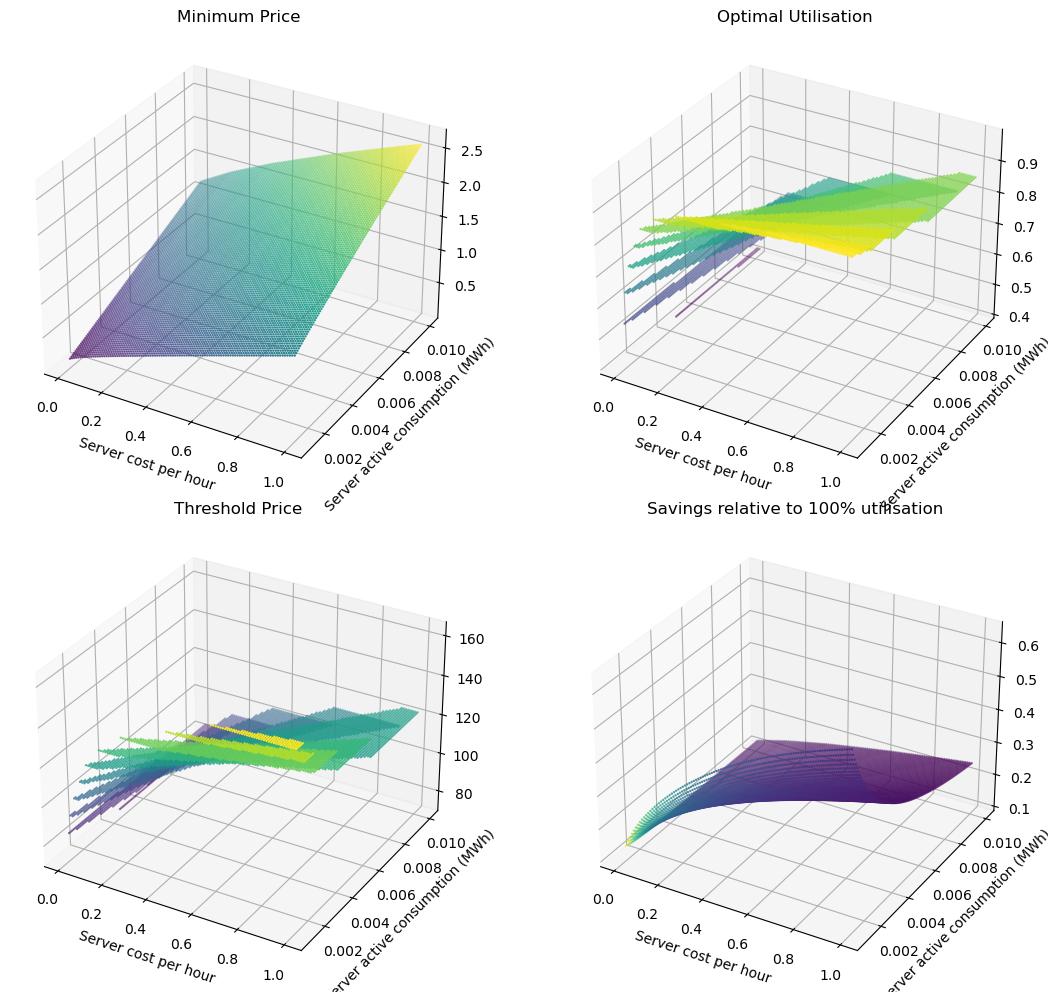

In [7]:
grid_max_fee = 16.7
server_cost_per_hour = np.linspace(0.01, 1, 100)
server_active_consumption_mwh = np.linspace(1e-3, 10e-3, 100)

min_price = np.ndarray((len(server_cost_per_hour), len(server_active_consumption_mwh)))
normal_price = np.ndarray((len(server_cost_per_hour), len(server_active_consumption_mwh))) # at 100% utilisation
opt_utilisation = np.ndarray((len(server_cost_per_hour), len(server_active_consumption_mwh)))
threshold = np.ndarray((len(server_cost_per_hour), len(server_active_consumption_mwh)))

for i, cost in enumerate(server_cost_per_hour):
    for j, consumption in enumerate(server_active_consumption_mwh):
        price_list = opt_cost(utilisation, probe_price, consumption, cost, grid_max_fee)
        min_price[i, j] = min(price_list)
        normal_price[i, j] = price_list[-1]
        opt_utilisation[i, j] = utilisation[np.argmin(price_list)]
        threshold[i, j] = probe_price[np.argmin(price_list)]

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')
X, Y = np.meshgrid(server_cost_per_hour, server_active_consumption_mwh, indexing='ij')

ax1.scatter(X.flatten(), Y.flatten(), min_price.flatten(), c=min_price.flatten(), cmap='viridis', s=0.5)
ax1.set_title("Minimum Price")
ax1.set_xlabel("Server cost per hour")
ax1.set_ylabel("Server active consumption (MWh)")

ax2.scatter(X.flatten(), Y.flatten(), opt_utilisation.flatten(), c=opt_utilisation.flatten(), cmap='viridis', s=0.5)
ax2.set_title("Optimal Utilisation")
ax2.set_xlabel("Server cost per hour")
ax2.set_ylabel("Server active consumption (MWh)")

ax3.scatter(X.flatten(), Y.flatten(), threshold.flatten(), c=threshold.flatten(), cmap='viridis', s=0.5)
ax3.set_title("Threshold Price")
ax3.set_xlabel("Server cost per hour")
ax3.set_ylabel("Server active consumption (MWh)")

ax4.scatter(X.flatten(), Y.flatten(), min_price.flatten() / normal_price.flatten(), c=threshold.flatten() / min_price.flatten(), cmap='viridis', s=0.5)
ax4.set_title("Savings relative to 100% utilisation")
ax4.set_xlabel("Server cost per hour")
ax4.set_ylabel("Server active consumption (MWh)")

plt.tight_layout()
plt.show()